<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [26]</a>'.</span>

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import nibabel as nib
import polars as pl
from tqdm import tqdm
import seaborn as sns
import polars as pl
import pickle
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import json
from sklearn.metrics import auc


In [2]:
plt.style.use("seaborn-v0_8-white")

In [3]:
ROOT = os.getcwd()
PREDICTED_DIR = os.path.join(ROOT, "workspace/test/labelsTs/predicted")
IMAGE_DIR = os.path.join(ROOT, "workspace/test/imagesTs")
TRUE_DIR = os.path.join(ROOT, "workspace/test/labelsTs/true")

In [4]:
with open(os.path.join(PREDICTED_DIR, "pdac-likelihood.json"), "r") as f:
    data = json.load(f)

# Convert the dict to a list of dicts and create a DataFrame
rows = [{"id": key, "pdac_likelihood": value} for key, value in data.items()]
predicted_pdac_scores = pl.DataFrame(
    rows,
    schema={
        "id": pl.Utf8,
        "pdac_likelihood": pl.Float64,
    },
)

In [5]:
predicted_pdac_scores

id,pdac_likelihood
str,f64
"""100006_00001_0000""",0.424344
"""100010_00001_0000""",0.002501
"""100020_00001_0000""",0.002595
"""100022_00001_0000""",0.002199
"""100023_00001_0000""",0.005653
…,…
"""101076_00001_0000""",0.001693
"""101078_00001_0000""",0.999844
"""101084_00001_0000""",0.002663


In [6]:
label_annotations = {
    0: "Background",
    1: "PDAC lesion",
    2: "Veins",
    3: "Arteries",
    4: "Pancreas parenchyma",
    5: "Pancreatic duct",
    6: "Common bile duct",
}

In [7]:
PDAC_LABEL = 1

In [8]:
true_labels = os.listdir(TRUE_DIR)

In [9]:
def get_label_distribution_for_image_labels(label_image_path: str) -> dict:
    label_image = nib.load(os.path.join(TRUE_DIR, label_image_path))
    data_arr = np.asanyarray(label_image.dataobj)
    unique, counts = np.unique(data_arr, return_counts=True)

    return {int(unique[i]): int(counts[i]) for i in range(len(unique))}

In [10]:
def get_image_with_true_labels(image_id: str) -> np.ndarray:
    label_image = nib.load(os.path.join(TRUE_DIR, image_id))
    data_arr = np.asanyarray(label_image.dataobj)
    return data_arr

In [11]:
# 3d image

In [12]:
true_label_image = nib.load("workspace/test/labelsTs/true/100006_00001.nii.gz")
image_arr = np.asanyarray(true_label_image.dataobj)
image_arr.shape

(512, 512, 240)

In [13]:
image_arr.shape

(512, 512, 240)

predicted_label_image = np.load(
    "workspace/test/labelsTs/predicted/itm/LowPred/100006_00001_0000.npz"
)
predicted_label_image.get("probabilities").shape

file = open("workspace/test/labelsTs/predicted/itm/LowPred/100006_00001_0000.pkl", "rb")

# dump information to that file
data = pickle.load(file)

data

# middle image slice
image = nib.load("workspace/test/imagesTs/100006_00001_0000.nii.gz")
image_arr = np.asanyarray(image.dataobj)
slice_index = image_arr.shape[2] // 2
image_slice = image_arr[:, :, slice_index]
plt.imshow(image_slice, cmap="gray")
plt.axis("off")
plt.title("Image slice")
plt.show()

colors = [
    "lightgray",  # 0: Background
    "red",  # 1: PDAC lesion (make it very visible!)
    "blue",  # 2: Veins
    "green",  # 3: Arteries
    "orange",  # 4: Pancreas parenchyma
    "purple",  # 5: Pancreatic duct
    "brown",  # 6: Common bile duct
]
cmap = ListedColormap(colors)

bounds = np.arange(len(label_annotations) + 1) - 0.5  # Boundaries for discrete colors
norm = Normalize(vmin=bounds.min(), vmax=bounds.max())

plt.figure(figsize=(8, 8))
plt.imshow(image_slice, cmap=cmap, norm=norm)
plt.title(f"True Labels for Slice {slice_index}")
plt.colorbar(
    ticks=range(len(label_annotations)),
    format=plt.FuncFormatter(lambda val, loc: label_annotations.get(val, "Unknown")),
)
plt.xlabel("X-coordinate (pixels)")
plt.ylabel("Y-coordinate (pixels)")
plt.show()

pdac_mask = image_arr[:, :, slice_index] == 1

plt.imshow(image_slice, cmap=cmap, norm=norm)

# Plot contours of the PDAC lesion
plt.contour(
    pdac_mask, colors="black", levels=[0.5]
)  # Levels=[0.5] makes it plot the boundary between 0 and 1
plt.title(f"True Labels with PDAC Lesion Boundary (Slice {slice_index})")
plt.colorbar(
    ticks=range(len(label_annotations)),
    format=plt.FuncFormatter(lambda val, loc: label_annotations.get(val, "Unknown")),
)
plt.xlabel("X-coordinate (pixels)")
plt.ylabel("Y-coordinate (pixels)")
plt.show()

pdac_only_slice = np.zeros_like(image_slice, dtype=float)
pdac_only_slice[image_slice == 1] = 1.0  # Set PDAC pixels to 1, others to 0

# Define a colormap for just the PDAC lesion (e.g., a red colormap)
cmap_pdac = ListedColormap(["none", "red"])  # 'none' for background, 'red' for PDAC

plt.figure(figsize=(8, 8))
# Plot the full labeled image first
plt.imshow(image_slice, cmap=cmap, norm=norm)
# Overlay the PDAC lesion with some transparency
plt.imshow(
    pdac_only_slice, cmap=cmap_pdac, alpha=0.5
)  # alpha makes it semi-transparent
plt.title(f"True Labels with Transparent PDAC Lesion (Slice {slice_index})")
plt.colorbar(
    ticks=range(len(label_annotations)),
    format=plt.FuncFormatter(lambda val, loc: label_annotations.get(val, "Unknown")),
)
plt.xlabel("X-coordinate (pixels)")
plt.ylabel("Y-coordinate (pixels)")
plt.show()

In [14]:
def contains_pdac_lession(label_image_file: str) -> np.ndarray:
    label_dist = get_label_distribution_for_image_labels(label_image_file)
    return label_dist.get(PDAC_LABEL, 0) > 0

np.unique([contains_pdac_lession(tl) for tl in true_labels], return_counts=True)

 `You have to use the same samples for the analysis of the old model and the newly trained model`


## ROC

* get the class probability thresholds [0, 1]
* determine if there is PDAC in the label
* get a confusion matrix for the test data, given the threshold
* get the true positive rate (TPR) and false positive rate (FPR)
* plot the ROC curve for all the thresholds
* get the area under the curve (AUC) for the ROC curve


In [15]:
class_thresholds = np.linspace(0, 1, 100)

In [16]:
label_distributions = {
    label: get_label_distribution_for_image_labels(label) for label in true_labels
}

In [17]:
# save distributions as json
with open("label_distributions.json", "w") as f:
    json.dump(label_distributions, f)
# load distributions from json
with open("label_distributions.json", "r") as f:
    label_distributions = json.load(f)

In [18]:
def get_cm_for_threshold(threshold: float) -> np.ndarray:
    cm = np.zeros((2, 2), dtype=int)
    for label, distribution in label_distributions.items():
        pdac_score = (
            predicted_pdac_scores.filter(pl.col("id") == label[:-7]+"_0000")
            .get_column("pdac_likelihood")
            .to_numpy()[0]
        )
        true_label = distribution.get(PDAC_LABEL, 0) > 0
        predicted_label = pdac_score > threshold
        cm[int(true_label), int(predicted_label)] += 1

    return cm

In [19]:
def plot_cm(threshold: float):
    cm = get_cm_for_threshold(threshold)
    fig, ax = plt.subplots()
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["No PDAC", "PDAC"],
        yticklabels=["No PDAC", "PDAC"],
        ax=ax,
    )
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(f"Confusion Matrix at Threshold {threshold:.2f}")
    plt.show()

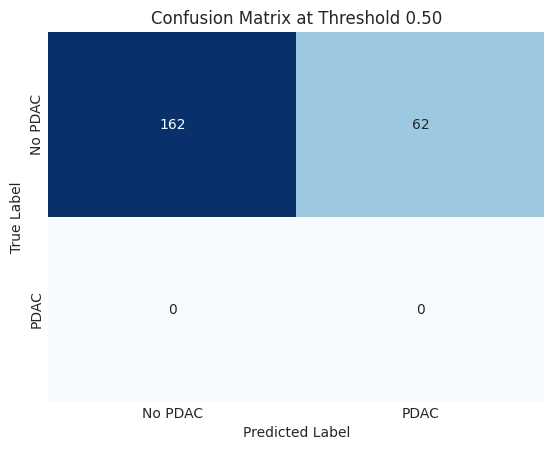

In [20]:
plot_cm(0.5)

In [21]:
def get_tpr_and_fpr(threshold: float) -> tuple:
    cm = get_cm_for_threshold(threshold)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return tpr, fpr

In [22]:
def plot_roc_with_auc_score():
    tpr_list = []
    fpr_list = []
    for threshold in class_thresholds:
        tpr, fpr = get_tpr_and_fpr(threshold)
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    auc_score = auc(tpr_list, fpr_list)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_list, tpr_list, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.fill_between(fpr_list, tpr_list, alpha=0.2)

    # add AUC score to the plot
    plt.text(
        0.5,
        0.2,
        f"AUC: {auc_score:.2f}",
        fontsize=12,
        ha="center",
        va="center",
        bbox=dict(facecolor="white", alpha=0.5),
    )
    plt.title("ROC Curve with AUC Score")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.show()

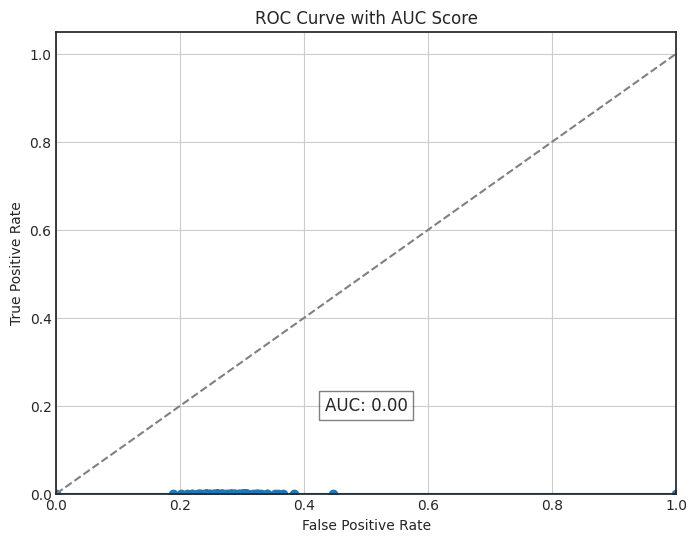

In [23]:
plot_roc_with_auc_score()

# Samples
* get a sample with no PDAC and a sample with PDAC
* get the predicted probability (incl. class) for each sample
* get saggital, mid, and axial slices for each sample and plot the true labels on top
* plot the predicted PDAC area, segmentation, for each samples


In [24]:
# get samples with PDAC and without PDAC from label_distributions
pdac_samples = [
    label
    for label, distribution in label_distributions.items()
    if distribution.get(PDAC_LABEL, 0) > 0
]
non_pdac_samples = [
    label
    for label, distribution in label_distributions.items()
    if distribution.get(PDAC_LABEL, 0) == 0
]

In [25]:
# get predicted pdac scores for pdac and non pdac samples
pdac_scores = [
    predicted_pdac_scores.filter(pl.col("id") == label[:-7]+"_0000")
    .get_column("pdac_likelihood")
    .to_numpy()[0]
    for label in pdac_samples
]
non_pdac_scores = [
    predicted_pdac_scores.filter(pl.col("id") == label[:-7]+"_0000")
    .get_column("pdac_likelihood")
    .to_numpy()[0]
    for label in non_pdac_samples
]

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [26]:
# random image for both pdac and non pdac
random_state = 42
np.random.seed(random_state)
pdac_sample = np.random.choice(pdac_samples)
non_pdac_sample = np.random.choice(non_pdac_samples)

ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:
def get_slices_for_image(image_id: str) -> dict:
    """Gets saggital, coronal and axial slices for a given image id"""
    image = nib.load(os.path.join(IMAGE_DIR, image_id))
    data_arr = np.asanyarray(image.dataobj)
    saggital_slice = data_arr[data_arr.shape[0] // 2, :, :]
    coronal_slice = data_arr[:, data_arr.shape[1] // 2, :]
    axial_slice = data_arr[:, :, data_arr.shape[2] // 2]
    return {
        "saggital": saggital_slice,
        "coronal": coronal_slice,
        "axial": axial_slice,
    }

In [ ]:
def from_label_to_training_id(label: str) -> str:
    """Converts label id to training id"""
    _label = str(label)
    _label = _label.split(".")
    training_id = f"{_label[0]}_0000.{_label[1]}.{_label[2]}"
    return training_id

In [ ]:
from_label_to_training_id(non_pdac_sample)

In [ ]:
non_pdac_sample

In [ ]:
def plot_true_and_predicted_segmentation(
    true_image_id: str):
    true_slices = get_slices_for_image(from_label_to_training_id(true_image_id))
    # predicted_slices = get_slices_for_image(predicted_image_id)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, (slice_type, true_slice) in enumerate(true_slices.items()):
        axes[0, i].imshow(true_slice, cmap="gray")
        axes[0, i].set_title(f"True {slice_type.capitalize()} Slice")
        axes[0, i].axis("off")

        # axes[1, i].imshow(predicted_slices[slice_type][:, :, slice_index], cmap="gray")
        # axes[1, i].set_title(f"Predicted {slice_type.capitalize()} Slice")
        # axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
plot_true_and_predicted_segmentation(
    pdac_sample
)

## Mislabelled samples

* get samples where the model predicted PDAC but the label is not PDAC
* get samples where the model predicted no PDAC but the label is PDAC
* get the predicted (incl. class) for each sample
* get saggital, mid, and axial slices for each sample and plot the true labels on top
* plot the predicted PDAC area, segmentation, for each samples


In [ ]:
# get a false negative sample
false_negative_samples = [
    label
    for label, distribution in label_distributions.items()
    if distribution.get(PDAC_LABEL, 0) > 0
    and predicted_pdac_scores.filter(pl.col("id") == label[:-7]+"_0000")
    .get_column("pdac_likelihood")
    .to_numpy()[0]
    < 0.5
]
# get a false positive sample
false_positive_samples = [
    label
    for label, distribution in label_distributions.items()
    if distribution.get(PDAC_LABEL, 0) == 0
    and predicted_pdac_scores.filter(pl.col("id") == label[:-7]+"_0000")
    .get_column("pdac_likelihood")
    .to_numpy()[0]
    > 0.5
]

In [ ]:
# random sample
random_false_negative_sample = np.random.choice(false_negative_samples)
random_false_positive_sample = np.random.choice(false_positive_samples)